<a href="https://colab.research.google.com/github/hxnguyen/Tram2Flows/blob/tram2flows_v2/Json_to_PNG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import html
import logging
import textwrap

import graphviz


In [17]:
VIZ_IGNORE_COMMON_PROPERTIES = (
    "created",
    "external_references",
    "id",
    "modified",
    "revoked",
    "spec_version",
    "type",
)

VIZ_IGNORE_SDOS = ("attack-flow", "extension-definition")

def label_escape(text):
    return graphviz.escape(html.escape(text))

def convert2dot(StixJson):
    dotObj = graphviz.Digraph()
    dotObj.body = _get_body_label(StixJson)
    ignored_ids = get_ignored_ids(StixJson)


    for o in StixJson['objects']:

      if o['type'] == "attack-action":
        dotObj.node(o['id'], _get_action_label(o), shape="plaintext", )
        for ref in o.get("asset_refs", []):
            dotObj.edge(o['id'], ref, "asset")
        for ref in o.get("effect_refs", []):
            dotObj.edge(o['id'], ref, "effect")

      elif o['type'] == "attack-asset":
        dotObj.node(o['id'], _get_asset_label(o), shape="plaintext")
        if object_ref := o.get("object_ref"):
            dotObj.edge(o['id'], object_ref, "object")

      elif o['type'] == "attack-condition":
        dotObj.node(o['id'], _get_condition_label(o), shape="plaintext")
        for ref in o.get("on_true_refs", []):
            dotObj.edge(o['id'], ref, "on_true")
        for ref in o.get("on_false_refs", []):
            dotObj.edge(o['id'], ref, "on_false")

      elif o['type'] == "attack-operator":
        dotObj.node(o['id'], o['operator'], shape="circle", style="filled", fillcolor="#ff9900", )
        for ref in o.get("effect_refs", []):
            dotObj.edge(o['id'], ref, "effect")

      elif o['type'] == "relationship":
        dotObj.edge(o['source_ref'], o['target_ref'], o['relationship_type'])

      elif o['id'] not in ignored_ids:
        dotObj.node(o['id'], _get_builtin_label(o), shape="plaintext")

    return dotObj

def _get_body_label(StixJson):
    flow = get_flow_object(StixJson)
    author = get_obj(StixJson, flow['created_by_ref'])

    description = "<br/>".join(
        textwrap.wrap(
            label_escape(flow.get("description", "(missing description)")), width=100
        )
    )
    lines = [
        f'<font point-size="24">{label_escape(flow["name"])}</font>',
        f"<i>{description}</i>",
        f'<font point-size="10">Author: {label_escape(author.get("name", "(missing)"))} &lt;{label_escape(author.get("contact_information", "n/a"))}&gt;</font>',
        f'<font point-size="10">Created: {flow.get("created", "(missing)")}</font>',
        f'<font point-size="10">Modified: {flow.get("modified", "(missing)")}</font>',
    ]
    label = "<br/>".join(lines)

    return [f"\tlabel=<{label}>;\n", '\tlabelloc="t";\n']

def _get_action_label(StixJson):
    if tid := StixJson.get("technique_id", None):
        heading = f"Action: {tid}"
    else:
        heading = "Action"
    description = "<br/>".join(
        textwrap.wrap(label_escape(StixJson.get("description", "")), width=40)
    )
    # confidence = confidence_num_to_label(StixJson.get("confidence", 95))
    ## need to retrieve probability of TTPs when feeding to tram before changing this
    confidence = 95
    name = label_escape(StixJson['name'])

    return "".join(
        [
            '<<TABLE BORDER="0" CELLBORDER="1" CELLSPACING="0" CELLPADDING="5">',
            f'<TR><TD BGCOLOR="#99ccff" COLSPAN="2"><B>{heading}</B></TD></TR>',
            f'<TR><TD ALIGN="LEFT" BALIGN="LEFT"><B>Name</B></TD><TD ALIGN="LEFT" BALIGN="LEFT">{name}</TD></TR>',
            f'<TR><TD ALIGN="LEFT" BALIGN="LEFT"><B>Description</B></TD><TD ALIGN="LEFT" BALIGN="LEFT">{description}</TD></TR>',
            f'<TR><TD ALIGN="LEFT" BALIGN="LEFT"><B>Confidence</B></TD><TD ALIGN="LEFT" BALIGN="LEFT">{confidence}</TD></TR>',
            "</TABLE>>",
        ]
    )

def _get_asset_label(StixJson):
    name = label_escape(StixJson['name'])
    description = "<br/>".join(
        textwrap.wrap(label_escape(StixJson.get("description", "")), width=40)
    )
    return "".join(
        [
            '<<TABLE BORDER="0" CELLBORDER="1" CELLSPACING="0" CELLPADDING="5">',
            f'<TR><TD BGCOLOR="#cc99ff" COLSPAN="2"><B>Asset: {name}</B></TD></TR>',
            f'<TR><TD ALIGN="LEFT" BALIGN="LEFT"><B>Description</B></TD><TD ALIGN="LEFT" BALIGN="LEFT">{description}</TD></TR>',
            "</TABLE>>",
        ]
    )

def _get_condition_label(StixJson):
    description = "<br/>".join(
        textwrap.wrap(label_escape(StixJson.description), width=40)
    )
    return "".join(
        [
            '<<TABLE BORDER="0" CELLBORDER="1" CELLSPACING="0" CELLPADDING="5">',
            '<TR><TD BGCOLOR="#99ff99" COLSPAN="2"><B>Condition</B></TD></TR>',
            f'<TR><TD ALIGN="LEFT" BALIGN="LEFT"><B>Description</B></TD><TD ALIGN="LEFT" BALIGN="LEFT">{description}</TD></TR>'
            "</TABLE>>",
        ]
    )

def _get_builtin_label(StixJson):
    title = StixJson['type'].replace("-", " ").title()
    lines = [
        '<<TABLE BORDER="0" CELLBORDER="1" CELLSPACING="0" CELLPADDING="5">',
        f'<TR><TD BGCOLOR="#cccccc" COLSPAN="2"><B>{title}</B></TD></TR>',
    ]
    for key, value in StixJson.items():
        if key in VIZ_IGNORE_COMMON_PROPERTIES:
            continue
        pretty_key = key.replace("_", " ").title()
        if isinstance(value, list):
            value = ", ".join(str(v) for v in value)
        pretty_value = label_escape(str(value))
        lines.append(
            f'<TR><TD ALIGN="LEFT" BALIGN="LEFT"><B>{pretty_key}</B></TD><TD ALIGN="LEFT" BALIGN="LEFT">{pretty_value}</TD></TR>'
        )
    lines.append("</TABLE>>")
    return "".join(lines)


def get_flow_object(StixJson):
    for obj in StixJson['objects']:
        if obj['type'] == "attack-flow":
            return obj

def get_obj(StixJson, id):
    for obj in StixJson['objects']:
        if obj['id'] == id:
            return obj

def get_ignored_ids(StixJson):
    ignored = set()

    # Ignore flow creator identity:
    flow = get_flow_object(StixJson)
    if flow_creator := flow.get("created_by_ref", None):
        ignored.add(flow_creator)

    # Ignore by SDO type:
    for obj in StixJson['objects']:
        if obj['type'] in VIZ_IGNORE_SDOS:
            ignored.add(obj['id'])

        # Ignore extension creator identity:
        if obj['type'] == "extension-definition" and (ext_creator := obj.get("created_by_ref", None)):
            ignored.add(ext_creator)

    return ignored

In [7]:
import json

with open("ANU1.json", 'r') as json_file:
    af_bundle = json.load(json_file)

print(af_bundle)

{'type': 'bundle', 'id': 'bundle--7efab79e-a059-11ee-b659-0242ac1c000c', 'spec_version': '2.1', 'created': '2023-12-21T23:34:33.795681Z', 'modified': '2023-12-21T23:34:33.795681Z', 'objects': [{'type': 'extension-definition', 'id': 'extension-definition--fb9c968a-745b-4ade-9b25-c324172197f4', 'spec_version': '2.1', 'created': '2022-08-02T19:34:35.143Z', 'modified': '2022-08-02T19:34:35.143Z', 'name': 'Attack Flow', 'description': 'Extends STIX 2.1 with features to create Attack Flows.', 'created_by_ref': 'identity--fb9c968a-745b-4ade-9b25-c324172197f4', 'schema': 'https://center-for-threat-informed-defense.github.io/attack-flow/stix/attack-flow-schema-2.0.0.json', 'version': '2.0.0', 'extension_types': ['new-sdo'], 'external_references': [{'source_name': 'Documentation', 'description': 'Documentation for Attack Flow', 'url': 'https://center-for-threat-informed-defense.github.io/attack-flow'}, {'source_name': 'GitHub', 'description': 'Source code repository for Attack Flow', 'url': 'htt

In [18]:
dotted = convert2dot(af_bundle)
print(dotted)

digraph {
	label=<<font point-size="24">ANU_filtered_reformed.txt</font><br/><i>(missing description)</i><br/><font point-size="10">Author: CaChepOmDua &lt;n/a&gt;</font><br/><font point-size="10">Created: 2023-12-21T23:34:33.795681Z</font><br/><font point-size="10">Modified: 2023-12-21T23:34:33.795681Z</font>>;
	labelloc="t";
	"attack-action--747bdbfe-a059-11ee-b659-0242ac1c000c" [label=<<TABLE BORDER="0" CELLBORDER="1" CELLSPACING="0" CELLPADDING="5"><TR><TD BGCOLOR="#99ccff" COLSPAN="2"><B>Action</B></TD></TR><TR><TD ALIGN="LEFT" BALIGN="LEFT"><B>Name</B></TD><TD ALIGN="LEFT" BALIGN="LEFT">Spearphishing Attachment</TD></TR><TR><TD ALIGN="LEFT" BALIGN="LEFT"><B>Description</B></TD><TD ALIGN="LEFT" BALIGN="LEFT"></TD></TR><TR><TD ALIGN="LEFT" BALIGN="LEFT"><B>Confidence</B></TD><TD ALIGN="LEFT" BALIGN="LEFT">95</TD></TR></TABLE>> shape=plaintext]
	"attack-action--747bdbfe-a059-11ee-b659-0242ac1c000c" -> "attack-asset--747bdf96-a059-11ee-b659-0242ac1c000c" [label=asset]
	"attack-action

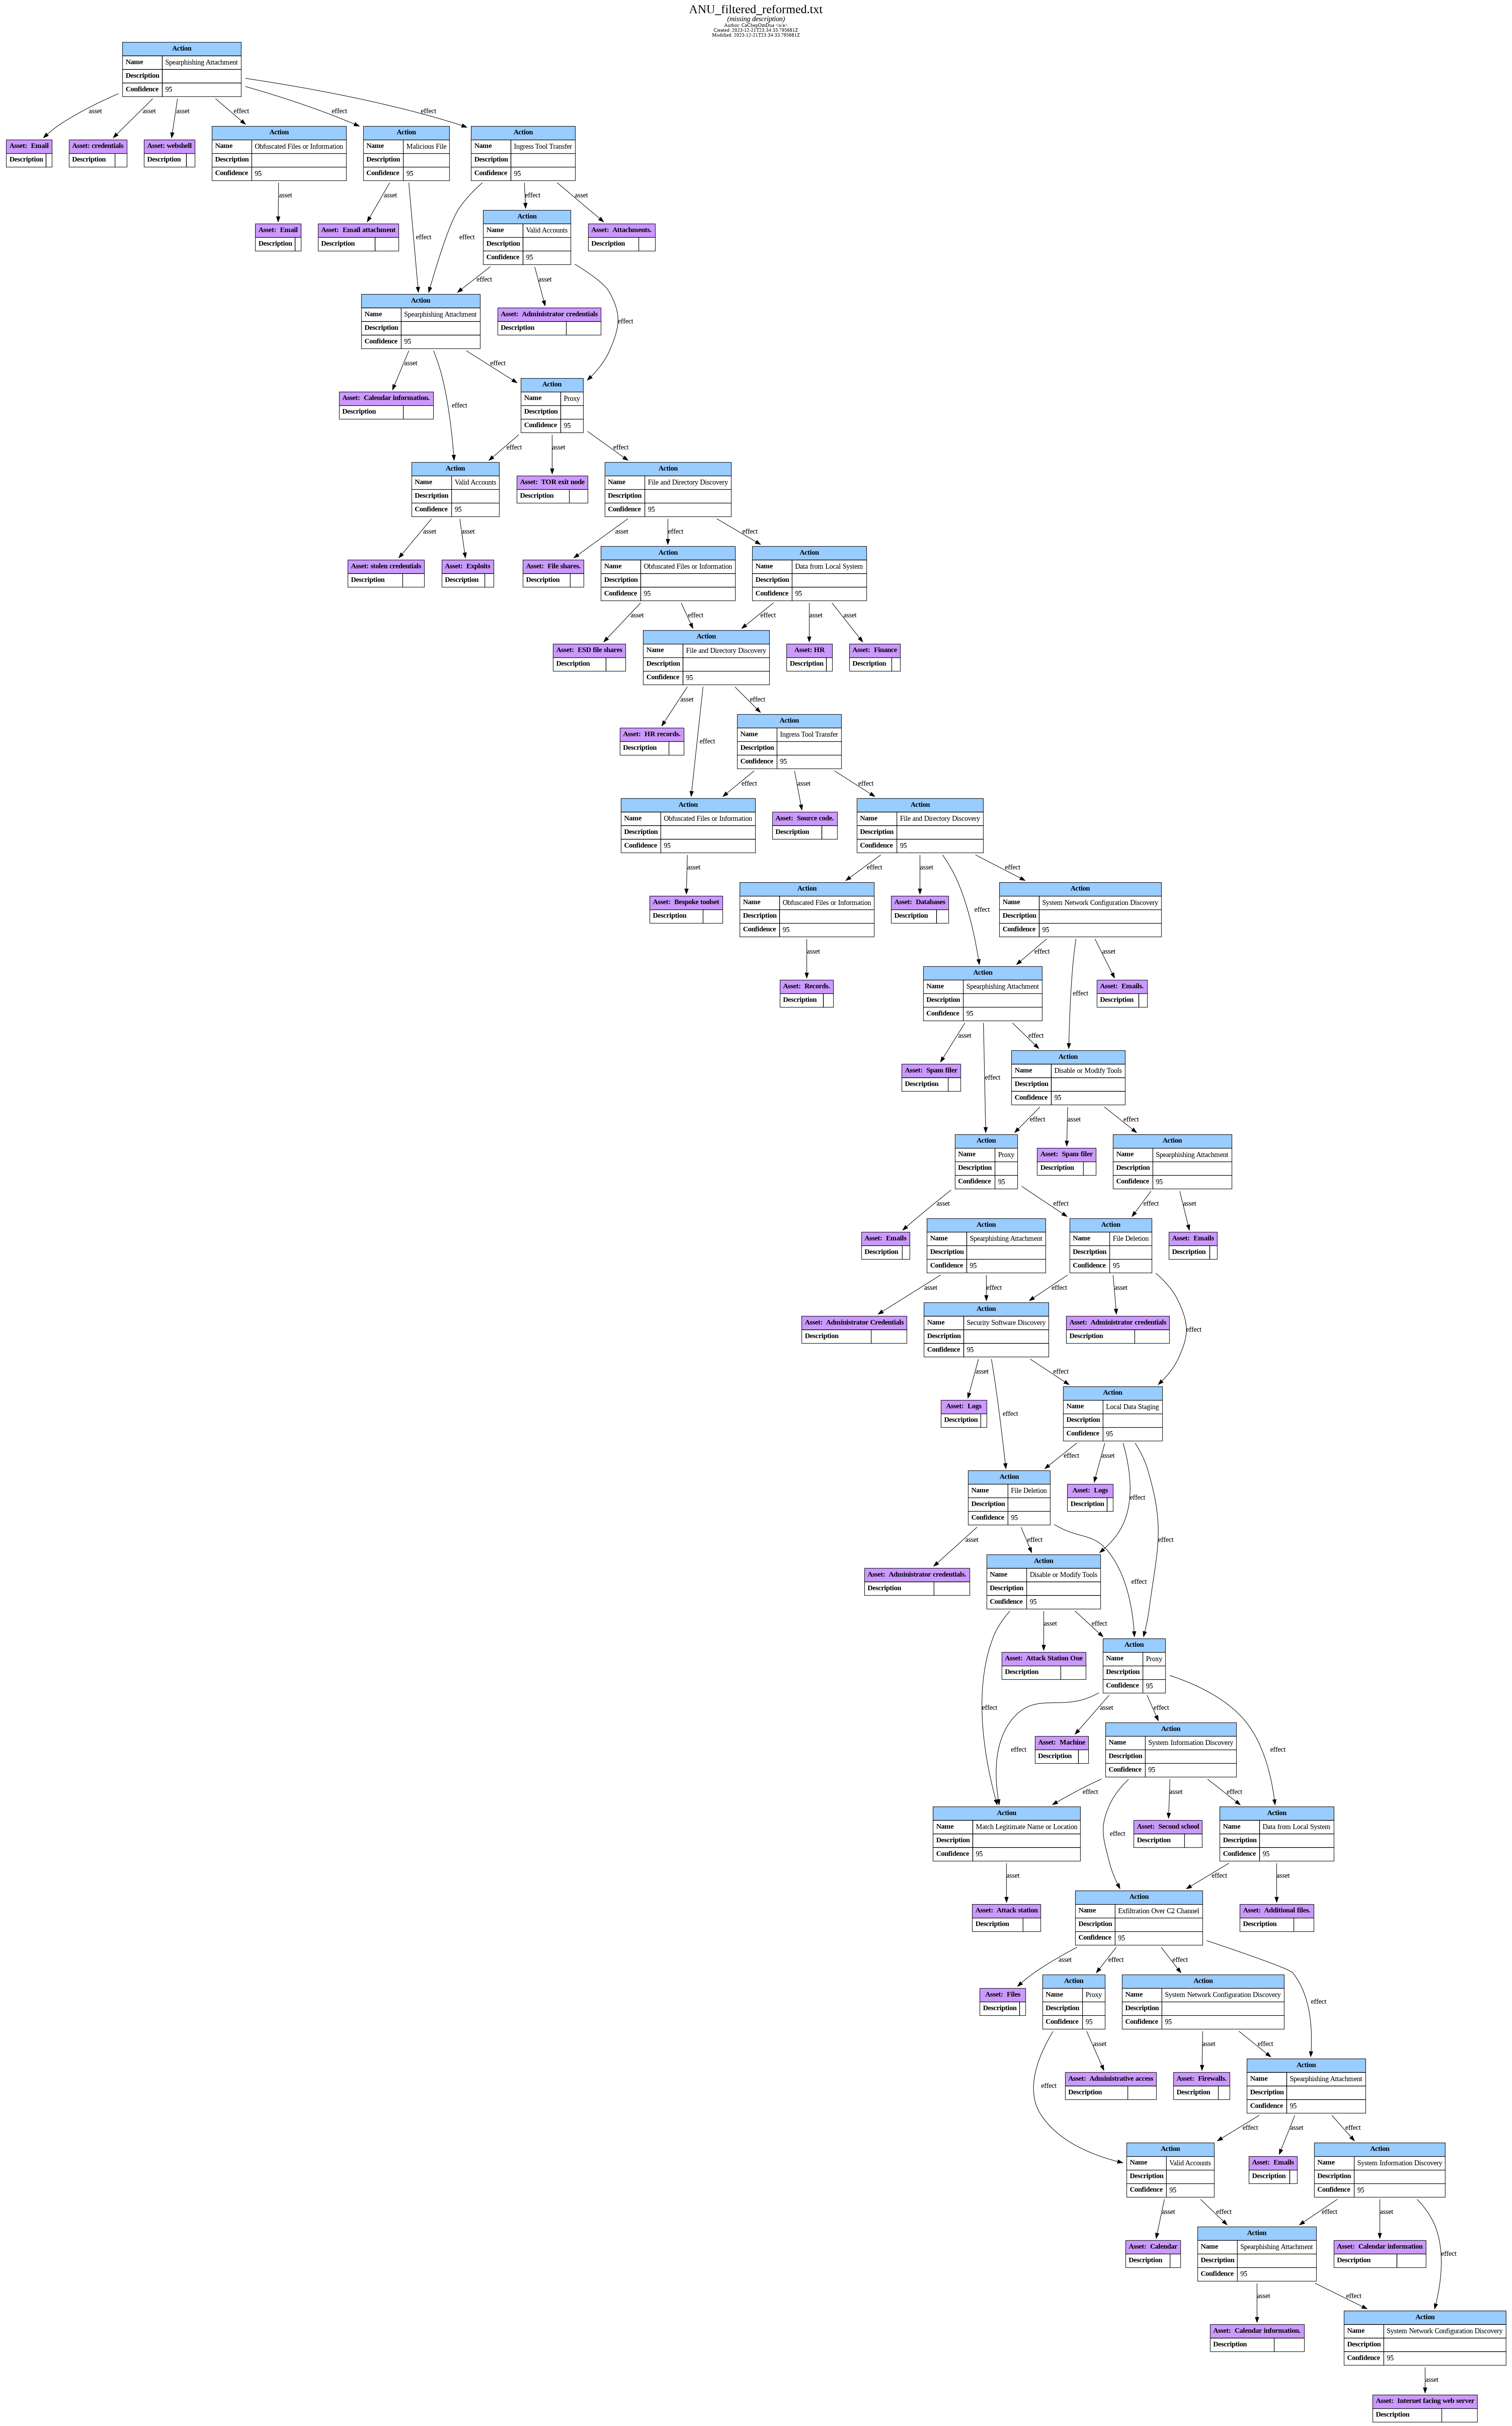

In [23]:
from IPython.display import Image, display
dotted.render('ANU', format='png', cleanup=True)
display(Image('ANU.png'))